In [1]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [2]:
IMG_SIZE = 128
base_path = r"C:\Users\debas\Desktop\Image Segmentation\Brain_MRI"

images = []
masks = []

for patient in tqdm(os.listdir(base_path)):
    patient_path = os.path.join(base_path, patient)
    
    if not os.path.isdir(patient_path):
        continue

    for file in os.listdir(patient_path):
        if file.endswith(".tif") and not file.endswith("_mask.tif"):
            img_path = os.path.join(patient_path, file)
            mask_path = os.path.join(patient_path, file.replace(".tif", "_mask.tif"))

            if os.path.exists(mask_path):
                img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
                mask = Image.open(mask_path).resize((IMG_SIZE, IMG_SIZE))

                img = np.array(img) / 255.0
                mask = np.array(mask) / 255.0
                mask = np.expand_dims(mask, axis=-1)

                images.append(img)
                masks.append(mask)

images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


100%|██████████| 112/112 [00:06<00:00, 17.43it/s]


Images shape: (3929, 128, 128, 3)
Masks shape: (3929, 128, 128, 1)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)


Train: (3143, 128, 128, 3)
Validation: (786, 128, 128, 3)


In [4]:
from tensorflow.keras import layers, Model

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(x, filters):
    f = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(f)
    return f, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

inputs = layers.Input(shape=(128, 128, 3))

f1, p1 = encoder_block(inputs, 16)
f2, p2 = encoder_block(p1, 32)
f3, p3 = encoder_block(p2, 64)

bottleneck = conv_block(p3, 128)

d1 = decoder_block(bottleneck, f3, 64)
d2 = decoder_block(d1, f2, 32)
d3 = decoder_block(d2, f1, 16)

outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d3)

model = Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │      8,224 │ conv2d_9[0][0]  

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

model.compile(
    optimizer="adam",
    loss=combined_loss,
    metrics=["accuracy"]
)


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_brain_tumor_unet.keras",   # file name
    monitor="val_loss",              # watch validation loss
    save_best_only=True,             # only save if better than before
    mode="min",                      # lower val_loss = better
    verbose=1
)


In [27]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=4,
    callbacks=[checkpoint]
)


Epoch 1/5
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9903 - loss: 0.5971
Epoch 1: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9903 - loss: 0.5971 - val_accuracy: 0.9921 - val_loss: 0.6208
Epoch 2/5
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9907 - loss: 0.5204
Epoch 2: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.9907 - loss: 0.5205 - val_accuracy: 0.9920 - val_loss: 0.6963
Epoch 3/5
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9912 - loss: 0.5135
Epoch 3: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.9912 - loss: 0.5135 - val_accuracy: 0.9924 - val_loss: 0.5611
Epoch 4/5
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9918 - loss: 0.5365
Epoch 4: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.9918 - loss: 0.5365 - val_accuracy: 0.9925 - val_loss:

In [28]:
from tensorflow import keras
model = keras.models.load_model("best_brain_tumor_unet.keras", compile=False)


In [29]:
preds = model.predict(X_val)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step


In [30]:
preds_binary = (preds > 0.5).astype("uint8")


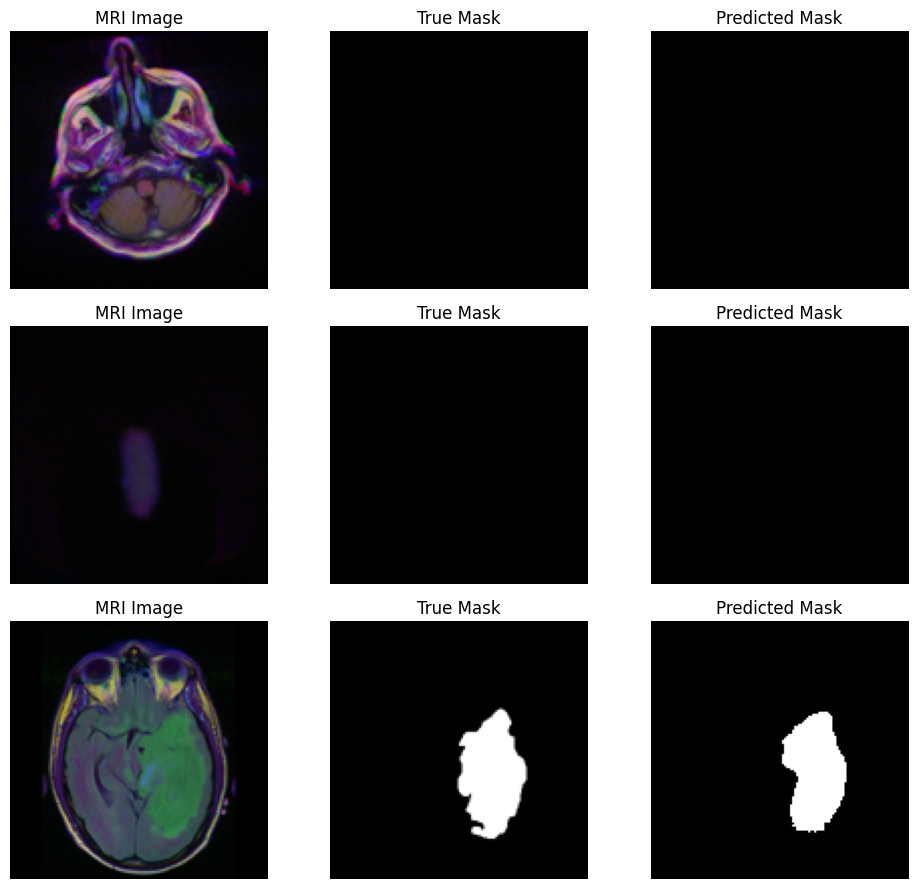

In [31]:
import random
import matplotlib.pyplot as plt

n = 3
indices = random.sample(range(len(X_val)), n)

plt.figure(figsize=(10, n * 3))

for i, idx in enumerate(indices):
    plt.subplot(n, 3, i*3 + 1)
    plt.imshow(X_val[idx])
    plt.title("MRI Image")
    plt.axis("off")

    plt.subplot(n, 3, i*3 + 2)
    plt.imshow(y_val[idx].squeeze(), cmap="gray")
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(n, 3, i*3 + 3)
    plt.imshow(preds_binary[idx].squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [33]:
from tensorflow import keras
model = keras.models.load_model("best_brain_tumor_unet.keras", compile=False)


In [34]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


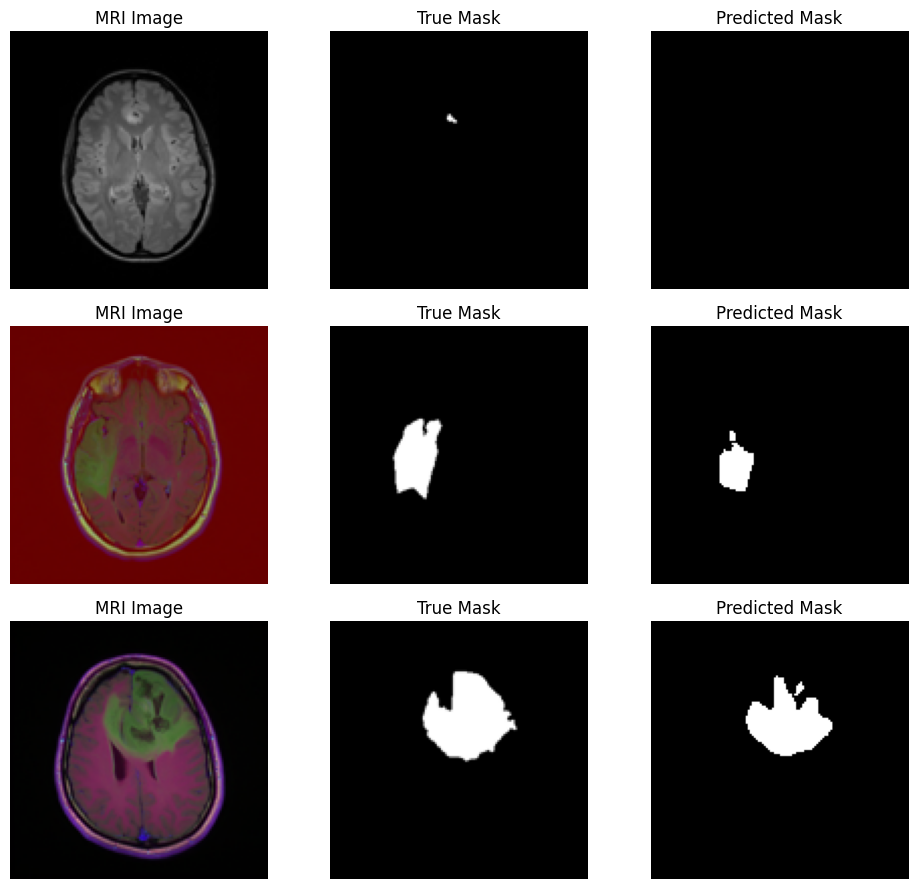

In [35]:
import random
import matplotlib.pyplot as plt

n = 3
indices = random.sample(range(len(X_val)), n)

plt.figure(figsize=(10, n * 3))

for i, idx in enumerate(indices):
    plt.subplot(n, 3, i*3 + 1)
    plt.imshow(X_val[idx])
    plt.title("MRI Image")
    plt.axis("off")

    plt.subplot(n, 3, i*3 + 2)
    plt.imshow(y_val[idx].squeeze(), cmap="gray")
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(n, 3, i*3 + 3)
    plt.imshow(preds_binary[idx].squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [36]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [37]:
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef]
)


In [38]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=4,
    callbacks=[checkpoint]
)


Epoch 1/10
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - dice_coef: 0.5615 - loss: 0.4917
Epoch 1: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - dice_coef: 0.5615 - loss: 0.4917 - val_dice_coef: 0.5405 - val_loss: 0.5067
Epoch 2/10
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - dice_coef: 0.5346 - loss: 0.5181
Epoch 2: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - dice_coef: 0.5343 - loss: 0.5184 - val_dice_coef: 0.3919 - val_loss: 0.6548
Epoch 3/10
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - dice_coef: 0.4651 - loss: 0.6028
Epoch 3: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - dice_coef: 0.4652 - loss: 0.6027 - val_dice_coef: 0.5317 - val_loss: 0.5227
Epoch 4/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - dice_coef: 0.5666 - loss: 0.4917
Epoch 4: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - dice_coef: 0.5666 - loss: 0.4917 - val_dice_coef: 0.

In [41]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),  # smaller than default 1e-3
    loss=bce_dice_loss,
    metrics=[dice_coef]
)


In [40]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=4,
    callbacks=[checkpoint]
)


Epoch 1/5
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - dice_coef: 0.5025 - loss: 0.5642
Epoch 1: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - dice_coef: 0.5025 - loss: 0.5641 - val_dice_coef: 0.4794 - val_loss: 0.5802
Epoch 2/5
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - dice_coef: 0.5225 - loss: 0.5357
Epoch 2: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - dice_coef: 0.5224 - loss: 0.5357 - val_dice_coef: 0.4764 - val_loss: 0.5755
Epoch 3/5
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - dice_coef: 0.5309 - loss: 0.5255
Epoch 3: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - dice_coef: 0.5309 - loss: 0.5255 - val_dice_coef: 0.5096 - val_loss: 0.5478
Epoch 4/5
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - dice_coef: 0.5326 - loss: 0.5254
Epoch 4: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - dice_coef: 0.5326 - loss: 0.5254 - val_dice_coef: 0.5156

In [42]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=4,
    callbacks=[checkpoint]
)


Epoch 1/5
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - dice_coef: 0.5321 - loss: 0.5234
Epoch 1: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - dice_coef: 0.5322 - loss: 0.5234 - val_dice_coef: 0.5308 - val_loss: 0.5266
Epoch 2/5
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - dice_coef: 0.5746 - loss: 0.4807
Epoch 2: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step - dice_coef: 0.5746 - loss: 0.4807 - val_dice_coef: 0.5398 - val_loss: 0.5165
Epoch 3/5
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - dice_coef: 0.5544 - loss: 0.5055
Epoch 3: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - dice_coef: 0.5544 - loss: 0.5055 - val_dice_coef: 0.5065 - val_loss: 0.5409
Epoch 4/5
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - dice_coef: 0.5653 - loss: 0.4893
Epoch 4: val_loss did not improve from 0.01940
786/786 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - dice_coef: 0.5653 - loss: 0.4893 - val_dice_coef: 0.5254

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_brain_tumor_unet_dice.keras",
    monitor="val_dice_coef",   # 👈 monitor Dice instead
    save_best_only=True,
    mode="max",                # higher Dice = better
    verbose=1
)


In [44]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    batch_size=4,
    callbacks=[checkpoint]
)


785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - dice_coef: 0.5697 - loss: 0.4820
Epoch 1: val_dice_coef improved from -inf to 0.54922, saving model to best_brain_tumor_unet_dice.keras
786/786 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - dice_coef: 0.5697 - loss: 0.4820 - val_dice_coef: 0.5492 - val_loss: 0.5034


In [45]:
import os
print([f for f in os.listdir() if f.endswith(".keras")])


['best_brain_tumor_unet.keras', 'best_brain_tumor_unet_dice.keras']


In [46]:
from tensorflow import keras
model = keras.models.load_model("best_brain_tumor_unet_dice.keras", compile=False)


In [47]:
import random
idx = random.randint(0, len(X_val)-1)

sample_img = X_val[idx]
sample_mask = y_val[idx]


In [48]:
pred_mask = model.predict(sample_img[np.newaxis, ...])[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


In [51]:
pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


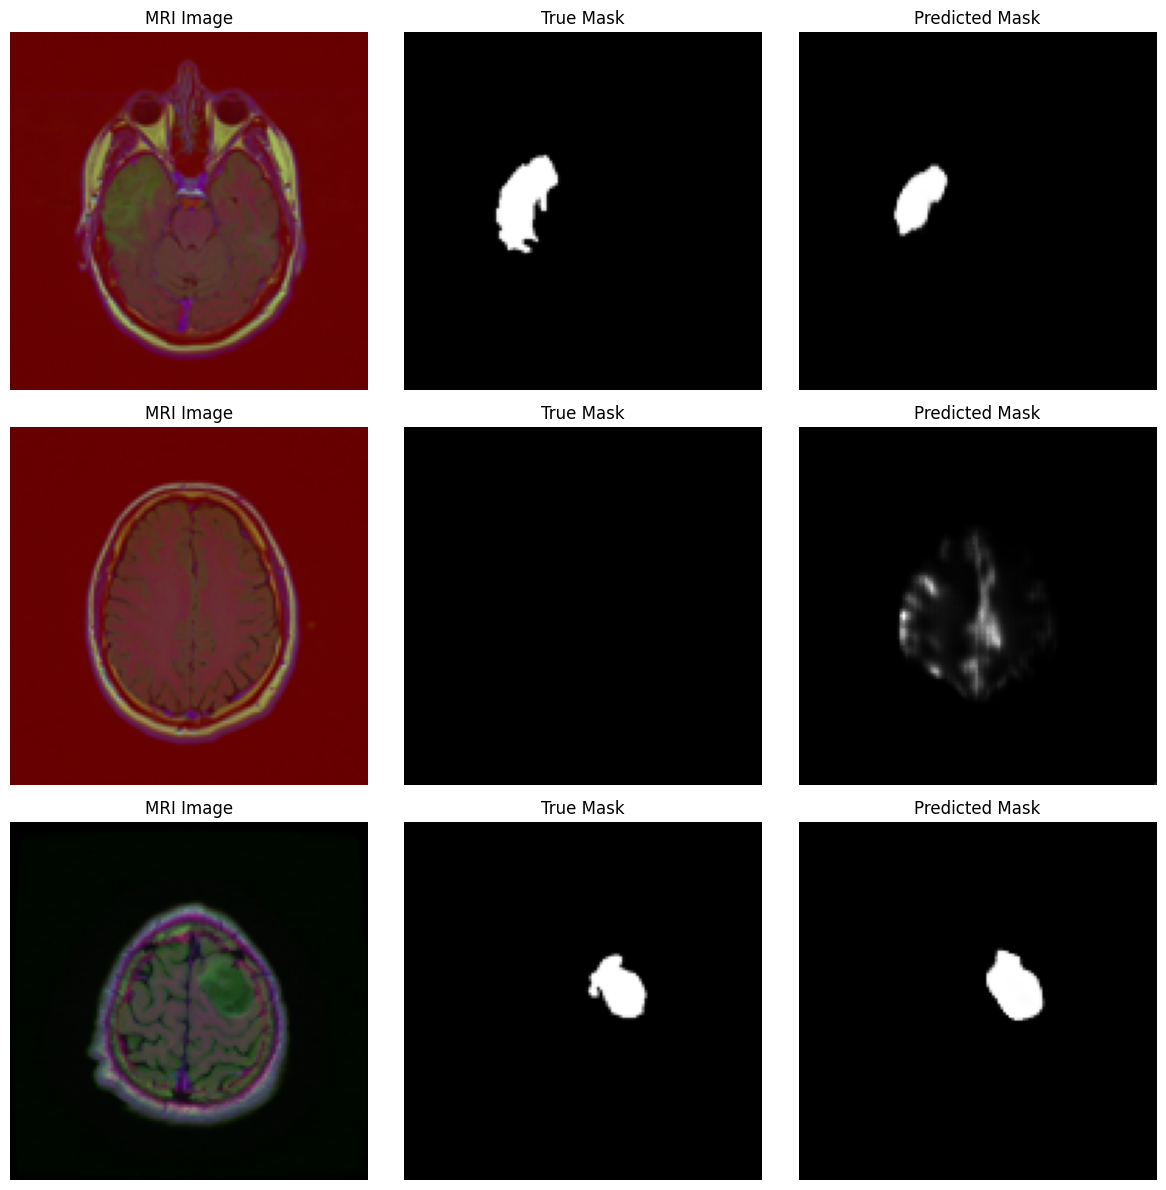

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for i in range(3):
    idx = random.randint(0, len(X_val)-1)
    
    sample_img = X_val[idx]
    true_mask = y_val[idx]
    
    pred_mask = model.predict(sample_img[np.newaxis, ...])[0]
    
    # MRI Image
    plt.subplot(3,3,i*3+1)
    plt.title("MRI Image")
    plt.imshow(sample_img)
    plt.axis("off")
    
    # Ground Truth
    plt.subplot(3,3,i*3+2)
    plt.title("True Mask")
    plt.imshow(true_mask.squeeze(), cmap="gray")
    plt.axis("off")
    
    # Prediction
    plt.subplot(3,3,i*3+3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [55]:
import tensorflow as tf

def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    return img, mask


In [56]:
batch_size = 4

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [57]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[checkpoint]
)


ValueError: You must call `compile()` before using the model.

In [58]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),   # small LR for stable Dice training
    loss=bce_dice_loss,                   # BCE + Dice loss we defined earlier
    metrics=[dice_coef]                   # track Dice score
)


In [59]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint]
)


Epoch 1/10
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - dice_coef: 0.5410 - loss: 0.5128
Epoch 1: val_dice_coef did not improve from 0.54922
786/786 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - dice_coef: 0.5410 - loss: 0.5128 - val_dice_coef: 0.5179 - val_loss: 0.5344
Epoch 2/10
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - dice_coef: 0.5516 - loss: 0.5022
Epoch 2: val_dice_coef did not improve from 0.54922
786/786 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - dice_coef: 0.5516 - loss: 0.5022 - val_dice_coef: 0.5242 - val_loss: 0.5281
Epoch 3/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - dice_coef: 0.5477 - loss: 0.5047
Epoch 3: val_dice_coef did not improve from 0.54922
786/786 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - dice_coef: 0.5477 - loss: 0.5047 - val_dice_coef: 0.5198 - val_loss: 0.5299
Epoch 4/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - dice_coef: 0.5413 - loss: 0.5111
Epoch 4: val_dice_coef improved from 0.54922 to 0.55133, saving model to best_brain_tumor_unet_dice.keras
786/786 ━━━━━━━━━━━━━━━

In [60]:
from tensorflow import keras
model = keras.models.load_model("best_brain_tumor_unet_dice.keras", compile=False)


In [61]:
pred_mask = model.predict(sample_img[np.newaxis, ...])[0]
pred_mask_bin = (pred_mask > 0.6).astype("uint8")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


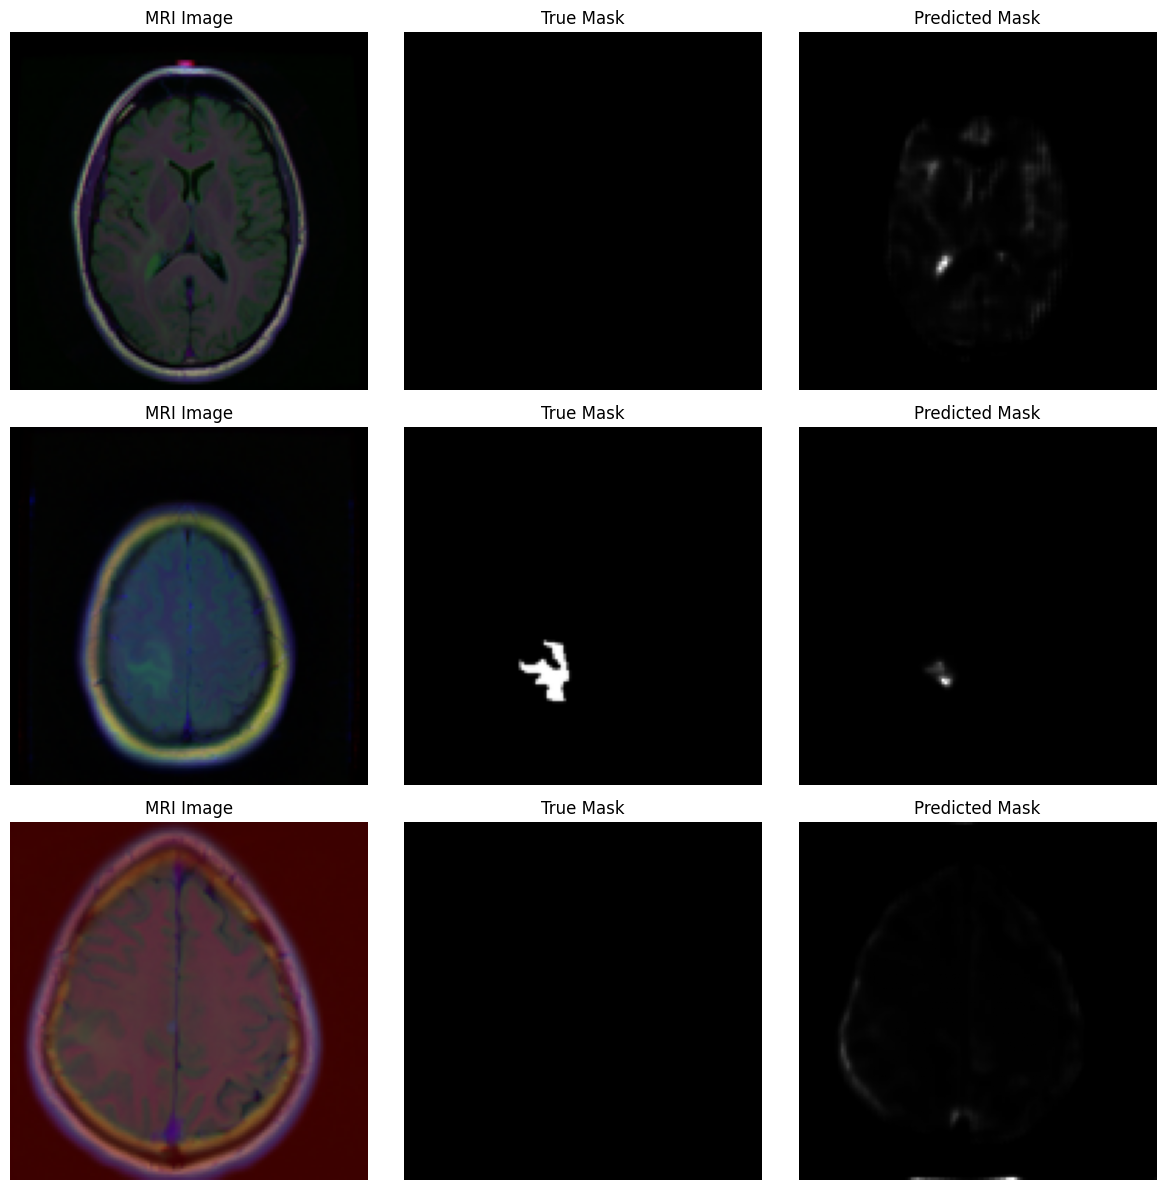

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

for i in range(3):
    idx = random.randint(0, len(X_val)-1)
    
    sample_img = X_val[idx]
    true_mask = y_val[idx]
    
    pred_mask = model.predict(sample_img[np.newaxis, ...])[0]
    
    # MRI Image
    plt.subplot(3,3,i*3+1)
    plt.title("MRI Image")
    plt.imshow(sample_img)
    plt.axis("off")
    
    # Ground Truth
    plt.subplot(3,3,i*3+2)
    plt.title("True Mask")
    plt.imshow(true_mask.squeeze(), cmap="gray")
    plt.axis("off")
    
    # Prediction
    plt.subplot(3,3,i*3+3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [64]:
def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    # Brightness change
    img = tf.image.random_brightness(img, 0.1)

    return img, mask


In [65]:
pred_mask_bin = (pred_mask > 0.65).astype("uint8")


In [66]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),   # small LR for stable Dice training
    loss=bce_dice_loss,                   # BCE + Dice loss we defined earlier
    metrics=[dice_coef]                   # track Dice score
)


In [67]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint]
)


Epoch 1/10
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - dice_coef: 0.5539 - loss: 0.4967
Epoch 1: val_dice_coef did not improve from 0.55646
786/786 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - dice_coef: 0.5539 - loss: 0.4967 - val_dice_coef: 0.5313 - val_loss: 0.5187
Epoch 2/10
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - dice_coef: 0.5499 - loss: 0.5009
Epoch 2: val_dice_coef improved from 0.55646 to 0.55959, saving model to best_brain_tumor_unet_dice.keras
786/786 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - dice_coef: 0.5500 - loss: 0.5008 - val_dice_coef: 0.5596 - val_loss: 0.4908
Epoch 3/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - dice_coef: 0.5663 - loss: 0.4834
Epoch 3: val_dice_coef did not improve from 0.55959
786/786 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - dice_coef: 0.5663 - loss: 0.4834 - val_dice_coef: 0.5515 - val_loss: 0.4981
Epoch 4/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - dice_coef: 0.5602 - loss: 0.4941
Epoch 4: val_dice_coef did not improve from 0.55959
786/786 ━━━━━━━━━━━━━━━

In [68]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_dice_coef",
    mode="max",
    patience=5,          # stop if no improvement for 5 epochs
    restore_best_weights=True,
    verbose=1
)


In [69]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_brain_tumor_unet_dice.keras",
    monitor="val_dice_coef",
    mode="max",
    save_best_only=True,
    verbose=1
)


In [70]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/20
785/786 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - dice_coef: 0.5779 - loss: 0.4695
Epoch 1: val_dice_coef improved from -inf to 0.55909, saving model to best_brain_tumor_unet_dice.keras
786/786 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step - dice_coef: 0.5779 - loss: 0.4695 - val_dice_coef: 0.5591 - val_loss: 0.4950
Epoch 2/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - dice_coef: 0.5602 - loss: 0.4907
Epoch 2: val_dice_coef improved from 0.55909 to 0.56918, saving model to best_brain_tumor_unet_dice.keras
786/786 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - dice_coef: 0.5602 - loss: 0.4907 - val_dice_coef: 0.5692 - val_loss: 0.4814
Epoch 3/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - dice_coef: 0.5777 - loss: 0.4687
Epoch 3: val_dice_coef improved from 0.56918 to 0.57594, saving model to best_brain_tumor_unet_dice.keras
786/786 ━━━━━━━━━━━━━━━━━━━━ 94s 119ms/step - dice_coef: 0.5777 - loss: 0.4687 - val_dice_coef: 0.5759 - val_loss: 0.4708
Epoch 4/20
786/786 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - 